# Intro to reimbursements: overview with visualization

This notebook provides an overview of the `2017-03-15-reimbursements.xz` dataset, which contains broad data regarding CEAP usage in all terms since 2009. 

It aims to provide an example of basic analyses and visualization by exploring topics such as:

- Evolution of avarege monthly spending along the years
- Avarege monthly spending per congressperson along the years
- Seasonality in reimbursements
- Reimbursements by type of spending
- Which party has the most spending congressmen?
- Who were the top spenders of all time in absolute terms?
- Who were the most hired suppliers by amount paid?
- Which are the most expensive individual reimbursements?
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams

%matplotlib inline

# Charts styling
plt.style.use('ggplot')
rcParams['figure.figsize'] = 15, 8
matplotlib.rcParams.update({'font.size': 14})
#rcParams['font.family'] = 'Georgia'

# Type setting for specific columns
#DTYPE = dict(cnpj=np.str, cnpj_cpf=np.str, ano=np.int16, term=np.str)

# Experimenting with 'category' type to reduce df size
DTYPE =dict(cnpj_cpf=np.str,\
            year=np.int16,\
            month=np.int16,\
            installment='category',\
            term_id='category',\
            term='category',\
            document_type='category',\
            subquota_group_id='category',\
            subquota_group_description='category',\
            #subquota_description='category',\
            subquota_number='category',\
            state='category',\
            party='category')

In [2]:
reimbursements = pd.read_csv('../data/2017-03-15-reimbursements.xz', \
                             dtype=DTYPE, low_memory=False, parse_dates=['issue_date'])

In [3]:
# Creates a DataFrame copy with fewer columns
r = reimbursements[['year', 'month', 'total_net_value', 'party', 'state', 'term', 'issue_date',\
        'congressperson_name', 'subquota_description','supplier', 'cnpj_cpf']]
r.head()

,year,month,total_net_value,party,state,term,issue_date,congressperson_name,subquota_description,supplier,cnpj_cpf
0,2009,4,130.00,PP,PR,2015.0,2009-04-06 00:00:00.0,DILCEU SPERAFICO,Fuels and lubricants,MELHOR POSTO DE COMBUSTÍVEIS LTDA,02989654001197
1,2009,4,135.00,PP,PR,2015.0,2009-04-07 00:00:00.0,DILCEU SPERAFICO,"Locomotion, meal and lodging",MELONGENA PARTICIPAÇÕES LTDA,09259358000450
2,2009,3,1000.00,PP,PR,2015.0,2009-03-12 00:00:00.0,DILCEU SPERAFICO,Maintenance of office supporting parliamentary...,ARY ANTONIO MOSCHETTA,01537369920
3,2009,4,170.00,PP,PR,2015.0,2009-04-14 00:00:00.0,DILCEU SPERAFICO,Fuels and lubricants,CONVER COMBUSTÍVEIS AUTOMÓVEIS LTDA,00038505000579
4,2009,4,100.11,PP,PR,2015.0,2009-04-09 00:00:00.0,DILCEU SPERAFICO,Fuels and lubricants,GRANDO E GROFF LTDA,00161576000211


## Questions & answers

### Evolution of avarege monthly spending along the years
Are congressmen spending more today in relation to past years?

#### How many congressmen in each year?

In [4]:
years = r.year.unique()

# Computes unique names in each year and saves into a pd.Series
d = dict()
for y in years:
    d[y] = len(r[r.year == y].congressperson_name.unique())

s = pd.Series(d)
s

2009    537
2010    546
2011    778
2012    560
2013    544
2014    564
2015    769
2016    573
2017    520
dtype: int64

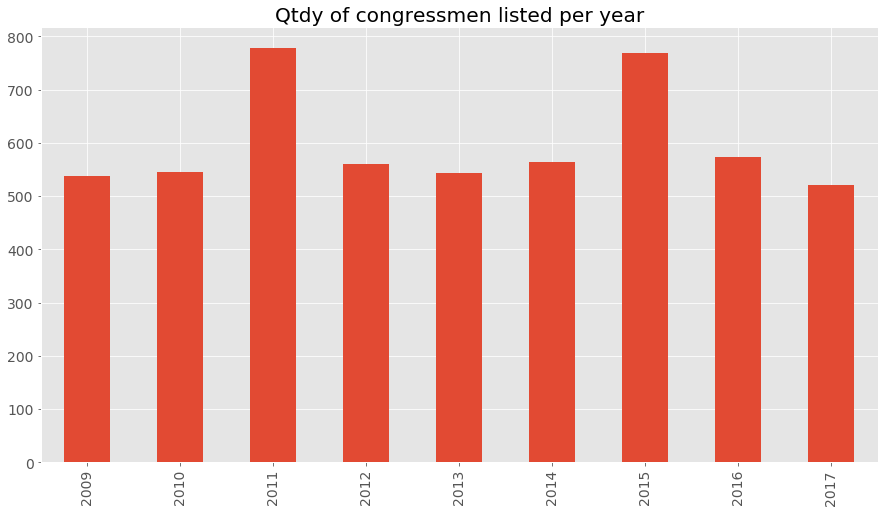

In [5]:
s.plot(kind='bar')
plt.title('Qtdy of congressmen listed per year')

#### How much did they spend, in average, per month in each year?

In [6]:
# Groups by name summing up spendings
a = r.groupby(['year']).sum().drop('month', 1)
a['congressmen_qty'] = s
a['monthly_value_per_congressmen'] = a['total_net_value'] / a['congressmen_qty'] / 12
a = a.drop(2017, 0)  # Neglets 2017

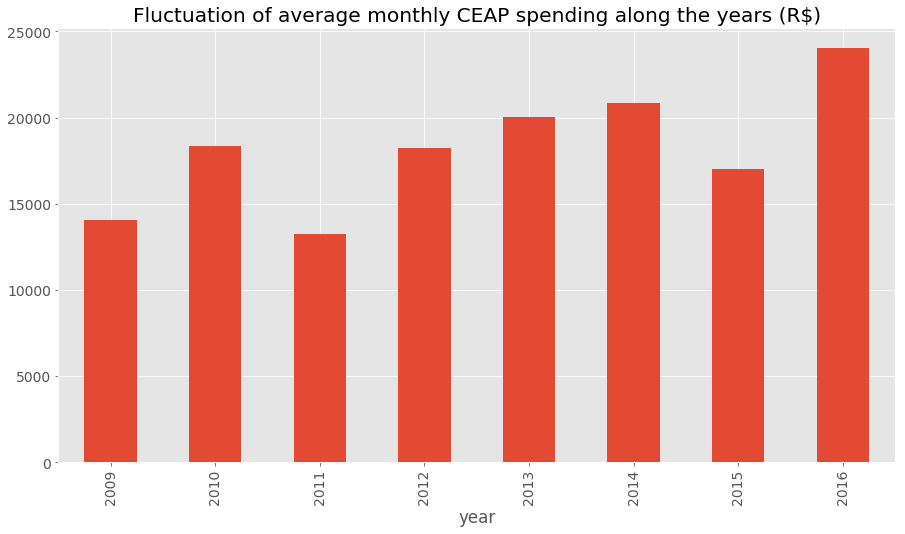

In [7]:
a.monthly_value_per_congressmen.plot(kind='bar')
plt.title('Fluctuation of average monthly CEAP spending along the years (R$)')

### Avarege monthly spending per congressperson along the years
This table shows the data above detailed per congressperson.

In [8]:
# Groups by name summing up spendings
a = r.groupby(['congressperson_name', 'year'])\
    .sum()\
    .drop('month', 1)

# Computes average spending per month and unstacks
a['monthly_total_net_value'] = a['total_net_value'] / 12
a = a.drop('total_net_value', 1).unstack()

# Creates subtotal column to the right
a['mean'] = a.mean(axis=1)

a.head()

monthly_total_net_value                            \
year                                   2009        2010          2011   
congressperson_name                                                     
ABEL MESQUITA JR.                       NaN         NaN           NaN   
ABELARDO CAMARINHA             14842.920833  23329.1400  13841.418333   
ABELARDO LUPION                18152.250000  21526.4125  23267.983333   
ACELINO POPÓ                            NaN         NaN  20218.460833   
ACÁCIO JÚNIOR                           NaN         NaN    764.000000   

                                                                             \
year                         2012          2013          2014          2015   
congressperson_name                                                           
ABEL MESQUITA JR.             NaN           NaN           NaN  32626.218333   
ABELARDO CAMARINHA   21381.600000  24442.093333  27206.505833   2693.010833   
ABELARDO LUPION      22145.420000  22246.507500  27486.450000   2497.000000   
ACELINO POPÓ         23457.991667  24405.267500  23608.119167   2604.166667   
ACÁCIO JÚNIOR                 NaN           NaN           NaN           NaN   

                                                      mean  
year                       2016         2017                
congressperson_name                                         
ABEL MESQUITA JR.    37927.9375  1685.588333  24079.914722  
ABELARDO CAMARINHA          NaN          NaN  18248.098452  
ABELARDO LUPION             NaN          NaN  19617.431905  
ACELINO POPÓ                NaN          NaN  18858.801167  
ACÁCIO JÚNIOR               NaN          NaN    764.000000

### Seasonality in reimbursements
Out of curiosity,in which period of the year more reimbursements were issued?

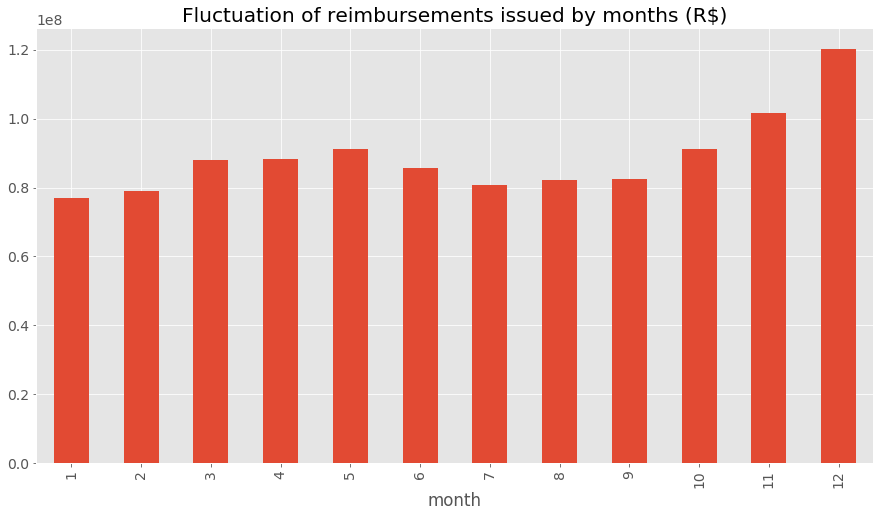

In [9]:
r.groupby('month')\
    .sum()\
    .total_net_value\
    .sort_index()\
    .plot(kind='bar')
    
plt.title('Fluctuation of reimbursements issued by months (R$)')

### Reimbursements by type of spending
For what are congressmen most using their quota?

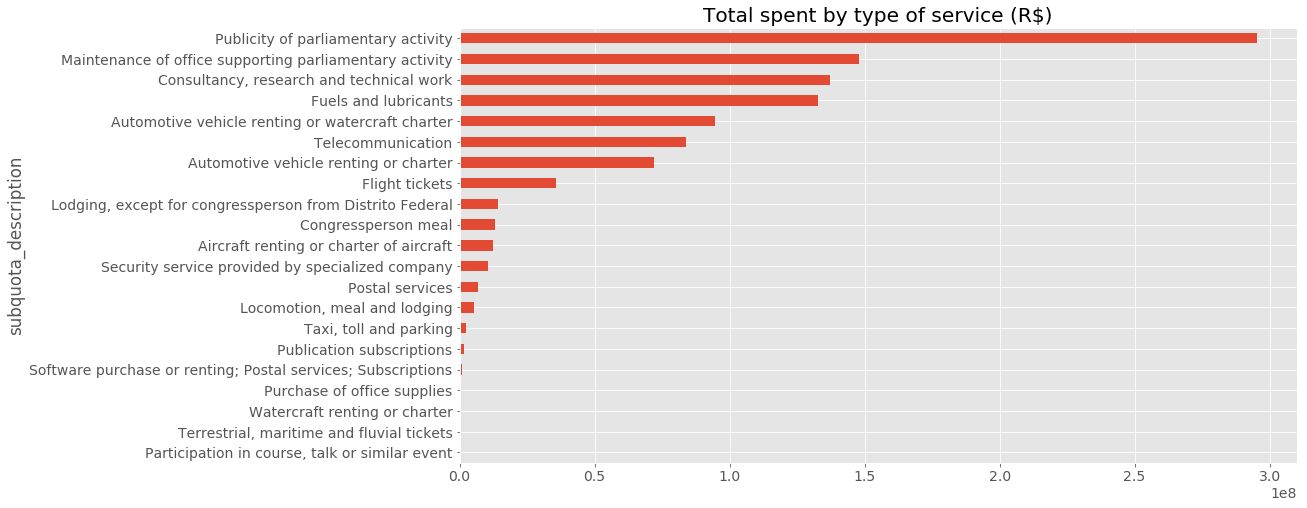

In [10]:
r.groupby('subquota_description')\
    .sum()\
    .total_net_value\
    .sort_values(ascending=True)\
    .plot(kind='barh')
    
plt.title('Total spent by type of service (R$)')

### Which party has the most spending congressmen?

##### How many congressmen in each party?

In [11]:
parties = r.party.unique()
parties

[PP, SD, PMDB, PSDB, PDT, ..., REDE, PRP, NaN, PSDC, PRTB]
Length: 32
Categories (31, object): [PP, SD, PMDB, PSDB, ..., REDE, PRP, PSDC, PRTB]

In [12]:
# Computes unique names in each party and saves into a pd.Series
d = dict()
for p in parties:
    d[p] = len(r[r.party == p].congressperson_name.unique())

s = pd.Series(d)
s

PP          82
SD          26
PMDB       179
PSDB       123
PDT         41
PTB         38
PT         156
PV          25
PSOL         8
PSD         67
PR          77
PSB         71
PSC         26
DEM         76
PCdoB       25
PRB         37
PHS          9
PPS         20
PEN          4
PTC          4
S.PART.      2
PTN         14
PSL          3
PROS        16
PMN          4
PTdoB        6
PMB          1
REDE         3
PRP          4
NaN          0
PSDC         1
PRTB         1
dtype: int64

#### How much did congressmen from each party spend in the year, in average? 

In [13]:
t = r.groupby('party').sum()
t = t.drop(['year', 'month'], 1)  # Removes useless columns

t['congressmen_per_party'] = s
years = len(r.year.unique())

In [14]:
t['monthly_value_per_congressperson'] = t['total_net_value'] / t['congressmen_per_party'] / (12*years)
t.sort_values(by='monthly_value_per_congressperson', ascending=False).head()

,total_net_value,congressmen_per_party,monthly_value_per_congressperson
party,,,
PMB,1.661347e+06,1,15382.839630
SD,3.274392e+07,26,11660.940499
PSD,7.858506e+07,67,10860.289638
PEN,4.584585e+06,4,10612.464907
PTdoB,6.809836e+06,6,10509.006590


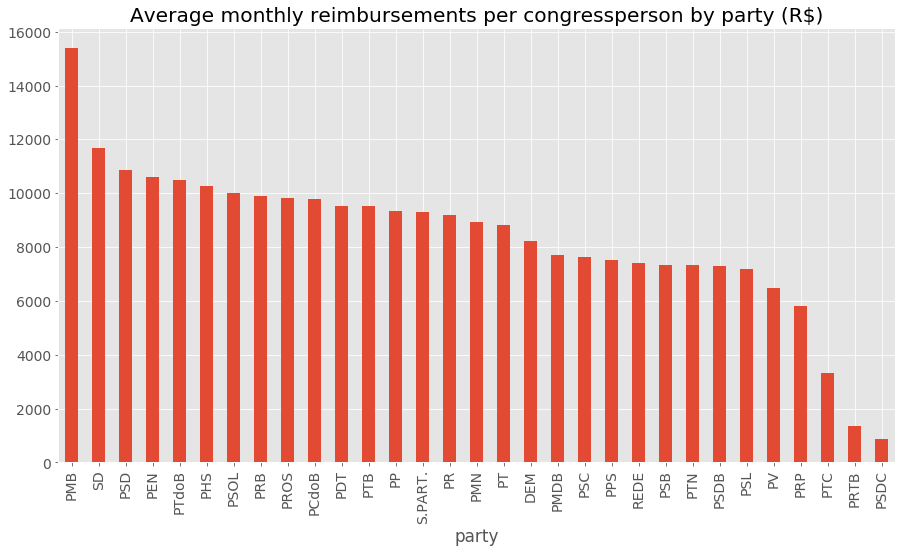

In [15]:
t.monthly_value_per_congressperson\
    .sort_values(ascending=False)\
    .plot(kind='bar')

plt.title('Average monthly reimbursements per congressperson by party (R$)')

### Who were the top spenders of all time in absolute terms?

In [16]:
r.groupby('congressperson_name')\
    .sum()\
    .total_net_value\
    .sort_values(ascending=False)\
    .head(10)

congressperson_name
WELLINGTON ROBERTO         3004465.11
CLEBER VERDE               2895861.67
RAIMUNDO GOMES DE MATOS    2777134.46
EFRAIM FILHO               2740068.65
GORETE PEREIRA             2682520.94
RENATO MOLLING             2675980.13
SILAS CÂMARA               2616348.57
DÉCIO LIMA                 2596289.87
NELSON MEURER              2565541.34
HERMES PARCIANELLO         2544743.67
Name: total_net_value, dtype: float64

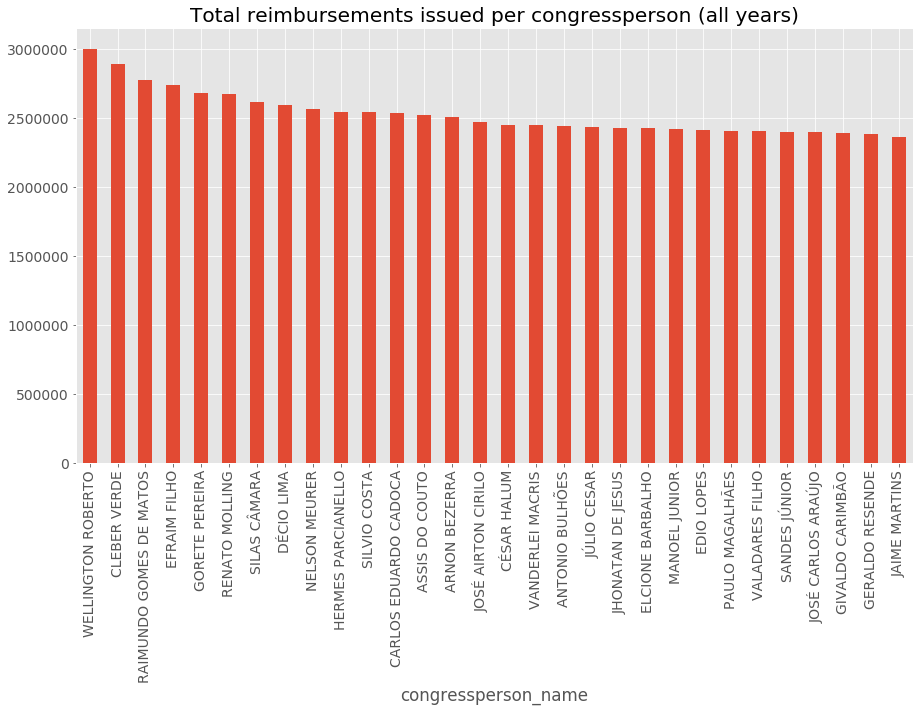

In [17]:
r.groupby('congressperson_name')\
    .sum()\
    .total_net_value\
    .sort_values(ascending=False)\
    .head(30)\
    .plot(kind='bar')

plt.title('Total reimbursements issued per congressperson (all years)')

### Who were the most hired suppliers by amount paid?
This table shows the top service providers by amount received in total (all years)

In [18]:
r.groupby(['cnpj_cpf', 'supplier', 'subquota_description'])\
    .sum()\
    .sort_values(by='total_net_value', ascending=False)\
    .head(20)

year  \
cnpj_cpf       supplier                          subquota_description                                   
22005529000130 DOUGLAS CUNHA DA SILVA ME         Consultancy, research and technical work    393064.0   
33000118000179 TELEMAR NORTE LESTE S/A           Telecommunication                         17316801.0   
04206050005140 TIM                               Telecommunication                          7917448.0   
15193908000136 JOSELY FERNANDA DO NASCIMENTO     Publicity of parliamentary activity         777777.0   
13230334000101 InCine Video Ltda - ME            Publicity of parliamentary activity         737736.0   
66970229000167 NEXTEL TELECOMUNICAÇÕES LTDA      Telecommunication                          3440930.0   
04206050005140 TIM CELULAR S/A                   Telecommunication                          5853269.0   
02558157000162 TELEFONICA BRASIL S.A.            Telecommunication                          5684336.0   
               TELEFÔNICA BRASIL S.A.            Telecommunication                          4252613.0   
               TELEFONICA                        Telecommunication                          5339342.0   
05443449000148 Vértice Associados                Consultancy, research and technical work    270051.0   
17589509000114 FATIMA FERREIRA DOS SANTOS ME     Publicity of parliamentary activity         175242.0   
04206050005140 TIM CELULAR S.A                   Telecommunication                          3299762.0   
66970229000167 NEXTEL                            Telecommunication                          2298493.0   
11130989000174 UNIGEST PROPAGANDA LTDA           Publicity of parliamentary activity          44311.0   
04206050000180 TIM CELULAR S.A.                  Telecommunication                          5112995.0   
00539486000130 STILO GRAFICA E EDITORA LTDA      Publicity of parliamentary activity          54382.0   
26198515000484 SEMPRE EDITORA LTDA.              Publicity of parliamentary activity         308255.0   
02570474000102 WULFERT DE OLIVEIRA & CIA LTDA    Automotive vehicle renting or charter       401024.0   
03953712000113 MAXWELL GRÁFICA E EDITORA LTDA ME Publicity of parliamentary activity          94626.0   

                                                                                             month  \
cnpj_cpf       supplier                          subquota_description                                
22005529000130 DOUGLAS CUNHA DA SILVA ME         Consultancy, research and technical work   1338.0   
33000118000179 TELEMAR NORTE LESTE S/A           Telecommunication                         57698.0   
04206050005140 TIM                               Telecommunication                         25916.0   
15193908000136 JOSELY FERNANDA DO NASCIMENTO     Publicity of parliamentary activity        2598.0   
13230334000101 InCine Video Ltda - ME            Publicity of parliamentary activity        2427.0   
66970229000167 NEXTEL TELECOMUNICAÇÕES LTDA      Telecommunication                         10078.0   
04206050005140 TIM CELULAR S/A                   Telecommunication                         19866.0   
02558157000162 TELEFONICA BRASIL S.A.            Telecommunication                         17988.0   
               TELEFÔNICA BRASIL S.A.            Telecommunication                          9648.0   
               TELEFONICA                        Telecommunication                         17454.0   
05443449000148 Vértice Associados                Consultancy, research and technical work    931.0   
17589509000114 FATIMA FERREIRA DOS SANTOS ME     Publicity of parliamentary activity         573.0   
04206050005140 TIM CELULAR S.A                   Telecommunication                         10821.0   
66970229000167 NEXTEL                            Telecommunication                          7099.0   
11130989000174 UNIGEST PROPAGANDA LTDA           Publicity of parliamentary activity         180.0   
04206050000180 TIM CELULAR S.A.                  Tel

#### Which congressmen hired the top supplier?

In [19]:
r.groupby(['supplier', 'cnpj_cpf', 'subquota_description', 'congressperson_name'])\
    .sum()\
    .sort_values(by='total_net_value', ascending=False)\
    .loc['DOUGLAS CUNHA DA SILVA ME']\
    .total_net_value

cnpj_cpf        subquota_description                      congressperson_name
22005529000130  Consultancy, research and technical work  SÉRGIO BRITO           388122.63
                                                          ROBERTO SALES          384800.00
                                                          MARCELO AGUIAR         370000.00
                                                          VINICIUS CARVALHO      343000.00
                                                          MAIA FILHO             255000.03
                                                          JOÃO CASTELO           210000.00
                                                          ROSANGELA GOMES        195000.01
                                                          ALBERTO FILHO          172473.58
                                                          MÁRCIO MARINHO         135000.00
                                                          ANDRÉ FUFUCA           132000.00
            

### Which are the most expensive individual reimbursements?

In [20]:
r = r.sort_values(by='total_net_value', ascending=False)
r.head(20)

,year,month,total_net_value,party,state,term,issue_date,congressperson_name,subquota_description,supplier,cnpj_cpf
773814,2012,12,215000.0,PTB,SP,2015.0,2012-12-14 00:00:00.0,ARNALDO FARIA DE SÁ,Publicity of parliamentary activity,BALCOLOR DIGITAL ATELIER GRAFICO LTDA,05511195000158
1141267,2014,12,208320.0,PTB,SP,2015.0,2014-12-19 00:00:00.0,ARNALDO FARIA DE SÁ,Publicity of parliamentary activity,GRÁFICA TRÊS PONTAS,54450705000130
969178,2013,12,197370.0,PTB,SP,2015.0,2013-12-27 00:00:00.0,ARNALDO FARIA DE SÁ,Publicity of parliamentary activity,BALCOLOR DIGITAL ATELIER GRAFICO LTDA,05511195000158
573671,2011,12,197000.0,PTB,SP,2015.0,2011-12-19 00:00:00.0,ARNALDO FARIA DE SÁ,Publicity of parliamentary activity,BALCOLOR,05511195000158
588639,2011,12,194100.0,PT,SP,2015.0,2011-12-26 00:00:00.0,ARLINDO CHINAGLIA,Publicity of parliamentary activity,ALL WIN PROPAGANDA LTDA,09023310000104
1020328,2014,11,190000.0,PP,GO,2015.0,2014-11-11 00:00:00.0,SANDES JÚNIOR,Publicity of parliamentary activity,GRAFICA CERRADO EIRELI ME,20185829000113
1283850,2015,12,189600.0,PTB,SP,2015.0,2015-12-18 00:00:00.0,ARNALDO FARIA DE SÁ,Publicity of parliamentary activity,GRÁFICA TRÊS PONTAS,54450705000130
1054459,2014,10,184500.0,PTB,AM,2015.0,2014-11-24 00:00:00.0,SABINO CASTELO BRANCO,Aircraft renting or charter of aircraft,MANAUS AEROTAXI PARTICIPAÇÕES LTDA,02324940000161
1484853,2016,12,184500.0,PTB,SP,2015.0,2016-12-21T00:00:00,ARNALDO FARIA DE SÁ,Publicity of parliamentary activity,GRÁFICA TRÊS PONTAS,54450705000130
998591,2014,12,167000.0,PHS,AL,2015.0,2014-12-30 00:00:00.0,GIVALDO CARIMBÃO,Publicity of parliamentary activity,INPRESS BRASILIA COMUNICAÇÃO VISUAL LTDA - ME,09432796000126
